<a href="https://colab.research.google.com/github/IvashchenkoDR/Stat_prak/blob/main/Home_work3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://drive.google.com/file/d/1b7tSyJBpWggHEBGdWa80JdKh7VNq2FEf/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Это нам просто в дальнейшем понадобится

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

samples = [rng() for _ in range(1000)]

## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

In [ ]:
def serial_test(samples, grid_divisions):
    series_length = 2  # фиксированная длина серии
    n_groups = len(samples) // series_length
    groups = np.array(samples[:n_groups * series_length]).reshape(n_groups, series_length)

    # Используем np.histogram2d для подсчёта точек в ячейках единичного квадрата
    hist, xedges, yedges = np.histogram2d(groups[:, 0], groups[:, 1],
                                          bins=grid_divisions, range=[[0, 1], [0, 1]])

    total_cells = grid_divisions ** 2
    expected = n_groups / total_cells
    chi_sq = np.sum((hist - expected) ** 2 / expected)

    df = total_cells - 1
    p_value = 1 - stats.chi2.cdf(chi_sq, df)

    return chi_sq, df, p_value


In [ ]:
grid_divisions = 10
serial_samles = serial_test(samples, grid_divisions)
print("Serial Test: χ² =", serial_samles[0], ", df =", serial_samles[1], ", p-value =", serial_samles[2])

Serial Test: χ² = 114.39999999999999 , df = 99 , p-value = 0.1380441495447643


### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

The choice of parameters $m$, $a$ and $c$ has a significant impact on the quality of the sequence. If the parameters are chosen unsuccessfully, it can lead to unexpected consequences:

In [ ]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

random = [rng_bad() for _ in range(30000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[3.051897510886192e-05,
 0.00018310965970158577,
 0.0008239871822297573,
 0.003295936156064272,
 0.012359732296317816,
 0.04449496837332845,
 0.15573221957311034,
 0.533938602078706,
 0.8020416363142431,
 0.006802399177104235]

The histogram of the distribution is similar to a uniform distribution:

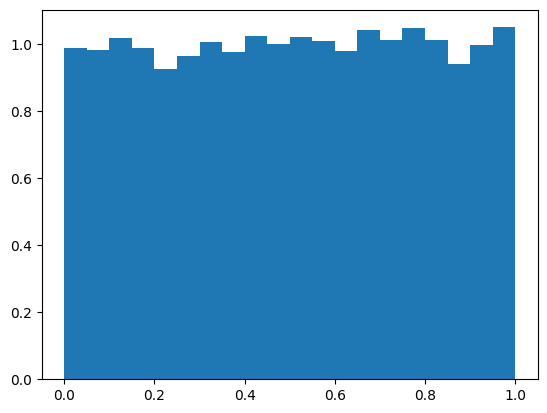

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.hist(random, 20, density=True)
plt.show()

However, the series test shows that the points are located on hyperplanes, which does not fit well with the notion of randomness:

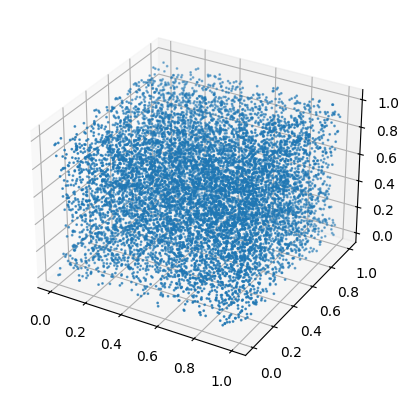

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(random[::3], random[1::3], random[2::3], s=1)
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(x=random[::3], y=random[1::3], z=random[2::3], opacity=0.1)
fig.update_traces(marker_size = 2)
fig.show()

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [ ]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1


def rng_good(m=2**31, a=8271241, c=2531011):
    rng_good.current = (a * rng_good.current + c) % m
    return rng_good.current / m
rng_good.current = 1

In [ ]:
# Одномерный χ²-тест для равномерности распределения
def chi_squared_test(samples, bins=10):
    counts, bin_edges = np.histogram(samples, bins=bins, range=(0, 1))
    n = len(samples)
    expected = n / bins
    chi_sq = np.sum((counts - expected)**2 / expected)
    df = bins - 1
    p_value = 1 - stats.chi2.cdf(chi_sq, df)

    return chi_sq, df, p_value
# Kolmogorov-Smirnov тест для проверки равномерного распределения
def ks_test(samples):
    statistic, p_value = stats.kstest(samples, 'uniform')
    return statistic, p_value


In [ ]:
def run_tests():
    sample_size = 10000
    bins = 10
    grid_divisions = 10

    samples_bad = [rng_bad() for _ in range(sample_size)]
    samples_good = [rng_good() for _ in range(sample_size)]

    # Serial Test
    serial_bad = serial_test(samples_bad, grid_divisions)
    serial_good = serial_test(samples_good, grid_divisions)

    # Одномерный chi^2-тест
    chi2_bad = chi_squared_test(samples_bad, bins)
    chi2_good = chi_squared_test(samples_good, bins)

    # Kolmogorov-Smirnov тест
    ks_bad = ks_test(samples_bad)
    ks_good = ks_test(samples_good)

    # Вывод результатов
    print("=== Результаты для rng_bad ===")
    print("Serial Test: chi^2 =", serial_bad[0], ", df =", serial_bad[1], ", p-value =", serial_bad[2])
    print("Chi-squared Test: chi^2 =", chi2_bad[0], ", df =", chi2_bad[1], ", p-value =", chi2_bad[2])
    print("Kolmogorov-Smirnov Test: statistic =", ks_bad[0], ", p-value =", ks_bad[1])

    print("\n=== Результаты для rng_good ===")
    print("Serial Test: chi^2 =", serial_good[0], ", df =", serial_good[1], ", p-value =", serial_good[2])
    print("Chi-squared Test: chi^2 =", chi2_good[0], ", df =", chi2_good[1], ", p-value =", chi2_good[2])
    print("Kolmogorov-Smirnov Test: statistic =", ks_good[0], ", p-value =", ks_good[1])

    # Графический вывод распределения для наглядности
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.hist(samples_bad, bins=bins, range=(0, 1), edgecolor='black')
    plt.title('rng_bad - Гистограмма')
    plt.xlabel('Значение')
    plt.ylabel('Частота')

    plt.subplot(1,2,2)
    plt.hist(samples_good, bins=bins, range=(0, 1), edgecolor='black')
    plt.title('rng_good - Гистограмма')
    plt.xlabel('Значение')
    plt.ylabel('Частота')

    plt.tight_layout()
    plt.show()


=== Результаты для rng_bad ===
Serial Test: chi^2 = 95.6 , df = 99 , p-value = 0.5780521305502355
Chi-squared Test: chi^2 = 8.812 , df = 9 , p-value = 0.45480628350619456
Kolmogorov-Smirnov Test: statistic = 0.006356765494495598 , p-value = 0.8113419470797673

=== Результаты для rng_good ===
Serial Test: chi^2 = 99.08000000000001 , df = 99 , p-value = 0.47883352664177214
Chi-squared Test: chi^2 = 11.730000000000002 , df = 9 , p-value = 0.2289621130033752
Kolmogorov-Smirnov Test: statistic = 0.007774031431227901 , p-value = 0.5785511754402629


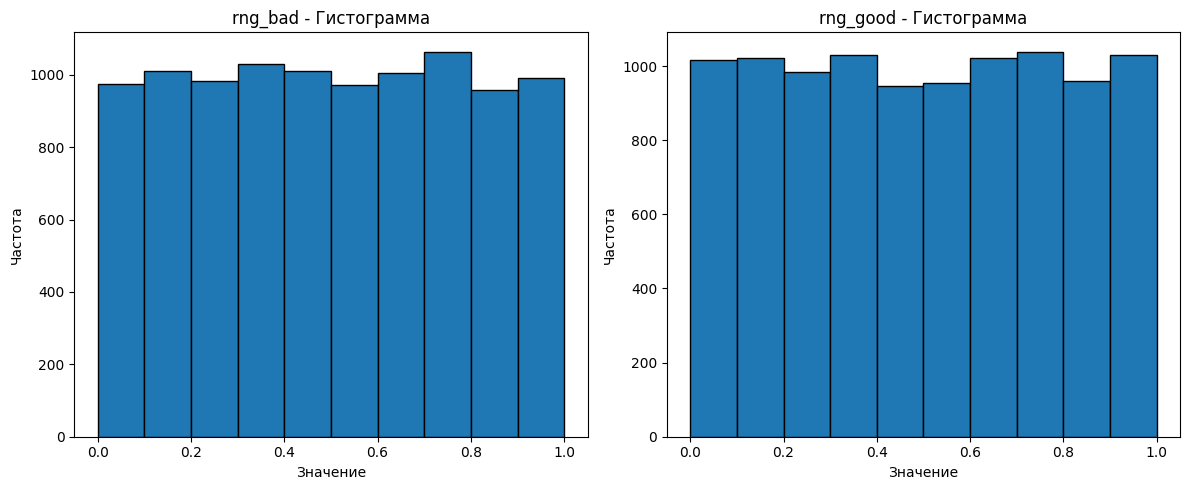

In [ ]:
run_tests()

* More randomness tests - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).
* More methods for generating a uniform value [here](https://en.wikipedia.org/wiki/List_of_random_number_generators).
* A story about dynamical systems and the transition to chaos https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

Я ожидал более явного расхождения но имеем что имеем


# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

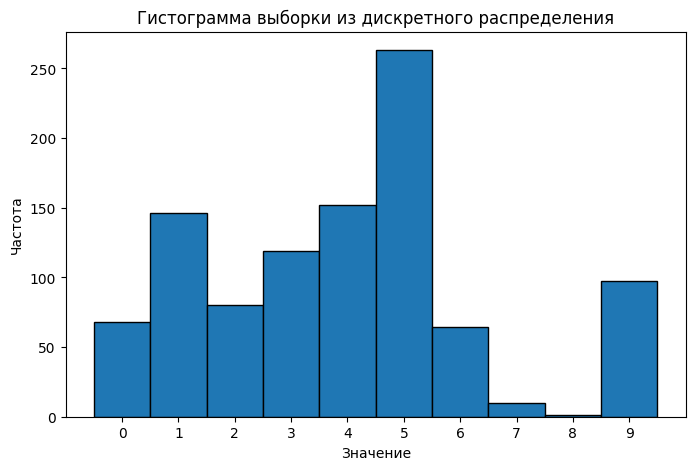

In [ ]:
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
values = np.arange(10)  # значения от 0 до 9

probabilities = weights / np.sum(weights)

# Вычисляем накопленные вероятности (cumulative distribution)
cum_probabilities = np.cumsum(probabilities)

n_samples = 1000
random_numbers = np.random.rand(n_samples)

sample_indices = np.searchsorted(cum_probabilities, random_numbers)

samples = values[sample_indices]

# Строим гистограмму
plt.figure(figsize=(8, 5))
plt.hist(samples, bins=np.arange(-0.5, 10.5, 1), edgecolor='black')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.title("Гистограмма выборки из дискретного распределения")
plt.xticks(values)
plt.show()


## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

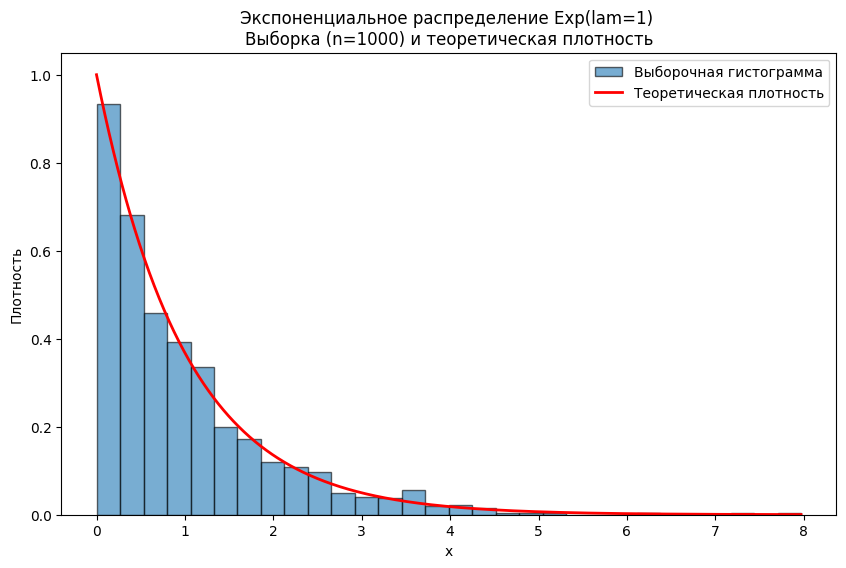

In [ ]:
lam = 1
n = 1000
u = np.random.rand(n)

samples = -np.log(1 - u) / lam

# Строим гистограмму выборки
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.6, edgecolor='black', label='Выборочная гистограмма')

# Строим теоретическую плотность экспоненциального распределения: f(x)=lam*e^(-lam*x)
x = np.linspace(0, np.max(samples), 1000)
density = lam * np.exp(-lam * x)
plt.plot(x, density, 'r-', lw=2, label='Теоретическая плотность')

plt.xlabel('x')
plt.ylabel('Плотность')
plt.title('Экспоненциальное распределение Exp(lam=1) \nВыборка (n=1000) и теоретическая плотность')
plt.legend()
plt.show()


## Rejection sampling (Accept-reject method)

The idea of the method is to sample from the distribution we know how to sample from, and then select points that follow the desired distribution. More precisely: let's say we know how to sample from a distribution with density $p$, and we want to sample from a distribution with density $\pi$. Let's take a random $x$ from the distribution $p$. Then take $y$ uniformly distributed on the interval $[0, p(x)]$. If the point $(x, y)$ falls under the graph of $\pi$, we take $x$ as a sampling element from $\pi$. If not, we repeat the procedure for a new $x$. The picture illustrates the idea of the method (the densities are normalised so that one lies entirely under the other):

<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

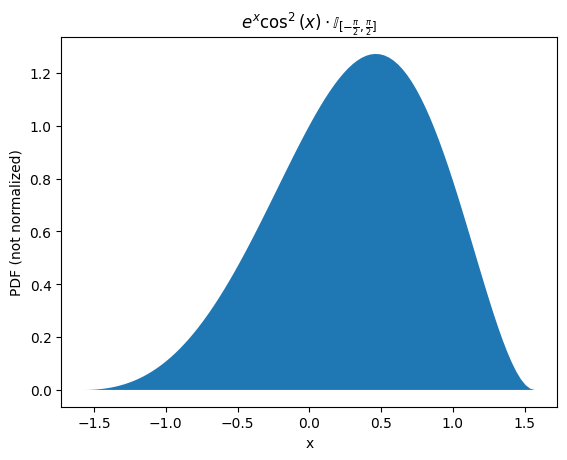

In [ ]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

<ipython-input-19-96302ad2b9ef>:32: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



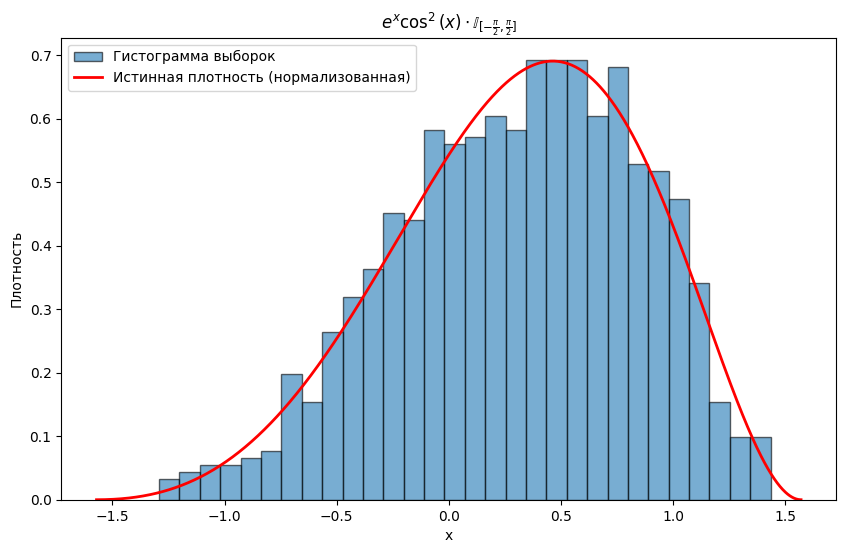

In [ ]:
def target_density(x):
    return np.exp(x) * np.cos(x) ** 2

x_min, x_max = -np.pi / 2, np.pi / 2

def proposal_sample(n):
    return np.random.uniform(x_min, x_max, n)

x_values = np.linspace(x_min, x_max, 1000)
max_density = np.max(target_density(x_values))

def accept_reject_sampling(n):
    samples = []
    while len(samples) < n:
        x_proposed = proposal_sample(1)[0]
        u = np.random.uniform(0, max_density)

        if u < target_density(x_proposed):
            samples.append(x_proposed)

    return np.array(samples)

n_samples = 1000
samples = accept_reject_sampling(n_samples)

# Строим гистограмму выборок
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.6, edgecolor='black', label='Гистограмма выборок')

# Строим график истинной плотности (не нормализованной)
x_plot = np.linspace(x_min, x_max, 1000)
density_plot = target_density(x_plot) / np.trapz(target_density(x_plot), x_plot)
plt.plot(x_plot, density_plot, 'r-', lw=2, label='Истинная плотность (нормализованная)')

plt.xlabel("x")
plt.ylabel("Плотность")
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')
plt.legend()
plt.show()


## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

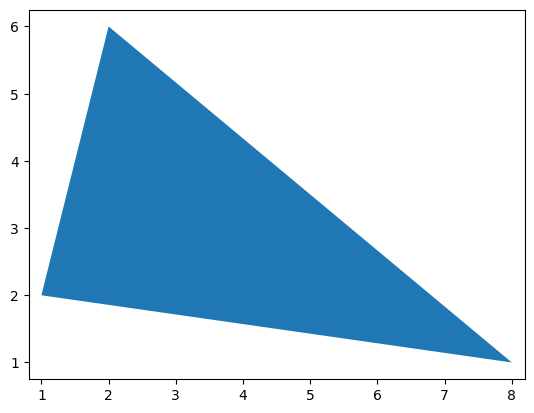

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

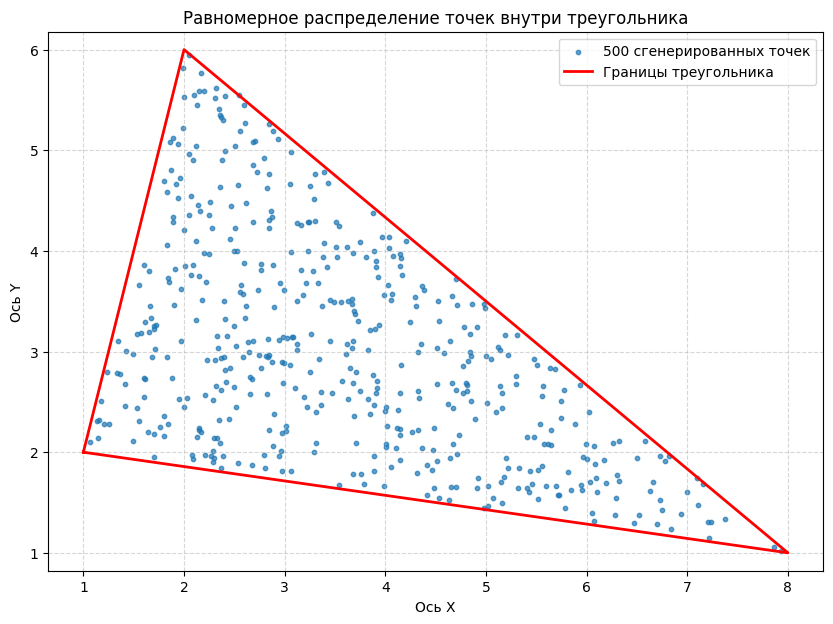

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_uniform_points_in_triangle(vertices, n_samples=500):

    if not isinstance(vertices, np.ndarray) or vertices.shape != (3, 2):
        raise ValueError("Параметр 'vertices' должен быть NumPy массивом формы (3, 2)")
    if not isinstance(n_samples, int) or n_samples <= 0:
        raise ValueError("Параметр 'n_samples' должен быть положительным целым числом")

    p0, p1, p2 = vertices[0, :], vertices[1, :], vertices[2, :]


    random_pairs = np.random.rand(n_samples, 2)
    r1 = random_pairs[:, 0]
    r2 = random_pairs[:, 1]
    sqrt_r1 = np.sqrt(r1)

    w0 = 1.0 - sqrt_r1
    w1 = sqrt_r1 * (1.0 - r2)
    w2 = sqrt_r1 * r2

    points = (w0[:, np.newaxis] * p0 +
              w1[:, np.newaxis] * p1 +
              w2[:, np.newaxis] * p2)

    return points



triangle_vertices = np.array([[1, 2], [2, 6], [8, 1]])

num_points = 500
generated_samples = generate_uniform_points_in_triangle(triangle_vertices, n_samples=num_points)

plt.figure(figsize=(10, 7))

plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=10, alpha=0.7, label=f'{num_points} сгенерированных точек')

triangle_outline_x = np.append(triangle_vertices[:, 0], triangle_vertices[0, 0])
triangle_outline_y = np.append(triangle_vertices[:, 1], triangle_vertices[0, 1])
plt.plot(triangle_outline_x, triangle_outline_y, 'r-', linewidth=2, label='Границы треугольника')

plt.title('Равномерное распределение точек внутри треугольника')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')

plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()



### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

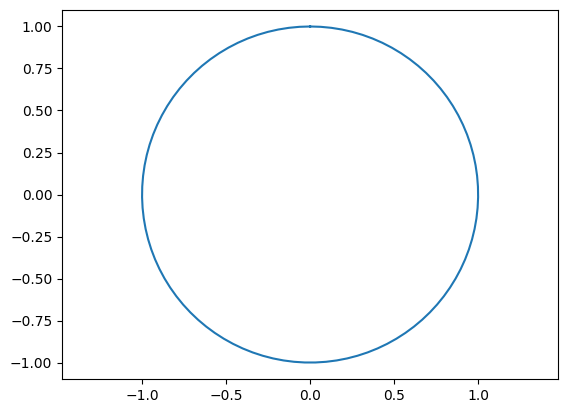

In [ ]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

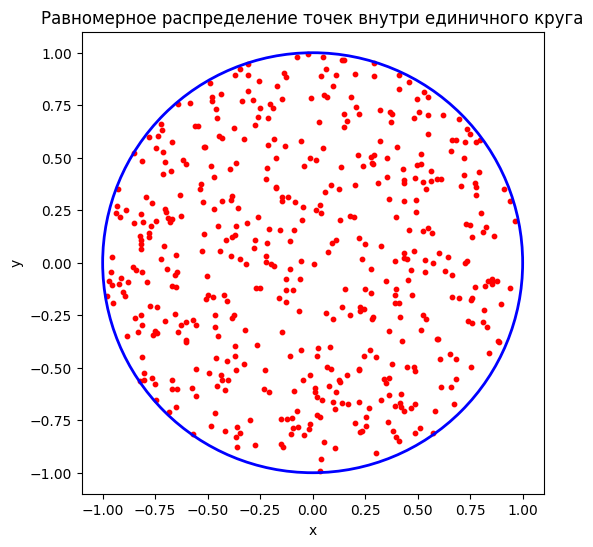

In [ ]:
N = 500
theta = 2 * np.pi * np.random.rand(N)
r = np.sqrt(np.random.rand(N))

x = r * np.cos(theta)
y = r * np.sin(theta)

# Построение графика
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='red', s=10)

circle = plt.Circle((0, 0), 1, edgecolor='blue', facecolor='none', linewidth=2)
plt.gca().add_patch(circle)

plt.title('Равномерное распределение точек внутри единичного круга')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
